In [1]:
import numpy as np
import pandas as pd
import xgboost
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import shap
# from matplotlib.pyplot 
from sklearn.metrics import accuracy_score

/workspaces/MLAlgoithms/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and Preprocess the Data
We'll use a sample heart disease dataset where each row represents a patient and columns represent various medical features.

In [2]:
# Load the dataset
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]
df = pd.read_csv(data_url, names=columns)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


In [4]:
for col in df.select_dtypes("O").columns:
    print(df[col].value_counts())

ca
0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: count, dtype: int64
thal
3.0    166
7.0    117
6.0     18
?        2
Name: count, dtype: int64


In [5]:
df = df.replace("?", np.nan)
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

### Dropping the nan or ? value rows as these are comparitively less in number

In [6]:
df = df.dropna()
df["ca"] = df["ca"].astype("float")
df["thal"] = df["thal"].astype("float")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    float64
 1   sex       297 non-null    float64
 2   cp        297 non-null    float64
 3   trestbps  297 non-null    float64
 4   chol      297 non-null    float64
 5   fbs       297 non-null    float64
 6   restecg   297 non-null    float64
 7   thalach   297 non-null    float64
 8   exang     297 non-null    float64
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    float64
 11  ca        297 non-null    float64
 12  thal      297 non-null    float64
 13  target    297 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 34.8 KB


#### Check for target distribution to decide on stratification during train test plit

In [7]:
df["target"].value_counts()

target
0    160
1     54
2     35
3     35
4     13
Name: count, dtype: int64

In [8]:
X = df.drop("target", axis = 1)
y = df["target"]
X_train,X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2, stratify=y)

In [9]:
xgb = xgboost.XGBClassifier(use_label_encode = False, objective = "multi:softmax", num_classes = 5)
xgb.fit(X_train, y_train)

/workspaces/MLAlgoithms/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:19:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "num_classes", "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_classes=5, num_parallel_tree=None, ...)

In [10]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

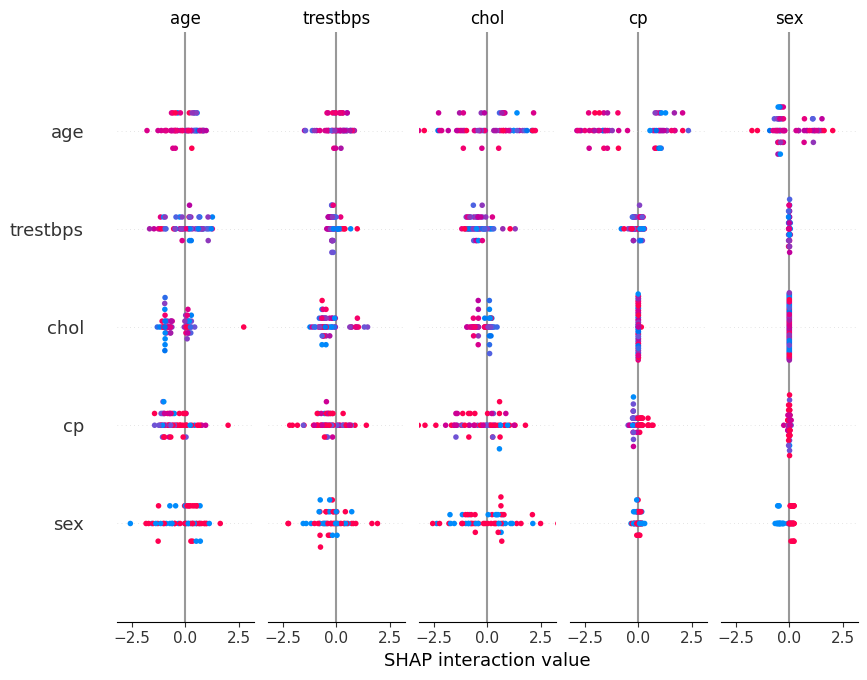

In [11]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
# SHAP dependence plot for a feature like "age"
shap.dependence_plot("age", shap_values, X_test)


IndexError: index 13 is out of bounds for axis 0 with size 13